# Train Platform Optimization (CSP) — Démonstration expérimentale

Ce notebook présente une **démonstration reproductible** (type “mini‑rapport expérimental”) pour le problème d’**allocation de quais** via **programmation par contraintes**.

## Objectif
Pour une instance “rush hour” de **N trains**, on cherche le **plus petit nombre de quais K** permettant d’affecter chaque train à un quai, **sans chevauchement temporel** (avec une marge de sécurité).

## Modèles comparés (Google OR‑Tools — CP‑SAT)
- **Modèle décomposé (coloration de graphe)** : contraintes binaires `Xi != Xj` sur le graphe de conflits.
- **Modèle global (scheduling)** : `AddNoOverlap` sur des intervalles optionnels par quai.

## Heuristiques
- `lexico` : décision simple (ordre naturel).
- `maxdeg` : ordre par degré de conflit (Fail‑First).
- `portfolio` : stratégie “portfolio search” (OR‑Tools).

> 🔎 **Solveur utilisé :** *Google OR‑Tools — CP‑SAT* via `ortools.sat.python.cp_model`.


## 0) Préparation Colab (clone + dépendances)

Ce notebook est conçu pour être lancé sur **Google Colab**.  
On installe les dépendances **manuellement** (pas via `requirements.txt`, comme demandé).

⚠️ Si votre session Colab a expiré : relancez simplement cette cellule.


In [ ]:
# --- Clone du repo (si nécessaire)
import os
from pathlib import Path

REPO_URL = "https://github.com/moussisto2/Train-Platform-Optimization-CSP.git"
PROJECT_DIR = Path("Train-Platform-Optimization-CSP")

if not PROJECT_DIR.exists():
    !git clone {REPO_URL}

%cd {PROJECT_DIR}

# --- Installation des dépendances (manuelle)
!pip -q install ortools pandas matplotlib


## 1) Imports et chargement du code

On importe le module `src/train_platform_csp.py`.

- Si l'import échoue (problème de `PYTHONPATH`), on ajoute le répertoire du projet au chemin Python.


In [2]:
import sys
from pathlib import Path

# Ajoute le répertoire courant au PYTHONPATH pour permettre: from src.train_platform_csp import ...
sys.path.append(str(Path(".").resolve()))

from src.train_platform_csp import (
    Train,
    generate_hard_instance,
    compute_conflicts,
    solve_decomposed,
    solve_global_nooverlap,
    run_benchmark,
    plot_results,
)
print("✅ Import OK : src.train_platform_csp")


✅ Import OK : src.train_platform_csp


## 2) Paramètres expérimentaux

On reprend les paramètres par défaut du script :
- `N_TRAINS = 130` (instance dense “rush hour”)
- `T_LIMIT = 5.0s` (timeout par résolution)
- `SAFETY = 2` (marge de sécurité)

Vous pouvez modifier `N_TRAINS` ou `T_LIMIT` si besoin, mais pour le rapport on garde ces valeurs.


## 3) Exécution du benchmark

La procédure :
1. Génération de l’instance
2. Construction du graphe de conflits (pour le modèle décomposé)
3. Balayage de `K` autour de la transition de phase
4. Collecte : statut, temps, conflits (OR‑Tools)

Le résultat est un `DataFrame` Pandas `df`.


In [3]:
df, n_trains, tlimit = run_benchmark()

# Aperçu
df.head()


--- Instance (rush hour) : 130 trains ---
Max degree (densité locale) = 107
Les INFEASIBLE au début sont normales (K trop petit).
-------------------------------------------------------------------------------------
Modèle     | Stratégie  | K   | Statut     | Temps(s)  | Conflits 
-------------------------------------------------------------------------------------
decomposed | lexico     | 64  | INFEASIBLE | 0.3219    | 0        
decomposed | maxdeg     | 64  | INFEASIBLE | 0.3823    | 0        
decomposed | portfolio  | 64  | INFEASIBLE | 0.3637    | 0        
global     | lexico     | 64  | TIMEOUT    | 5.0045    | 4738     
global     | fixed      | 64  | TIMEOUT    | 5.0072    | 4614     
global     | portfolio  | 64  | TIMEOUT    | 5.0054    | 18623    
decomposed | lexico     | 65  | INFEASIBLE | 0.1985    | 0        
decomposed | maxdeg     | 65  | INFEASIBLE | 0.1988    | 0        
decomposed | portfolio  | 65  | INFEASIBLE | 0.1864    | 0        
global     | lexico     | 65

,model,k,strategy,symmetry,status,time,conflicts
0,decomposed,64,lexico,True,INFEASIBLE,0.321850,0
1,decomposed,64,maxdeg,True,INFEASIBLE,0.382262,0
2,decomposed,64,portfolio,True,INFEASIBLE,0.363695,0
3,global,64,lexico,True,UNKNOWN,5.004512,4738
4,global,64,fixed,True,UNKNOWN,5.007217,4614


## 4) Sauvegarde des résultats (CSV + figures)

On crée un dossier `results/` et on y place :
- `results.csv`
- `decomposed_time.png`
- `global_time.png`


✅ CSV : results/results.csv


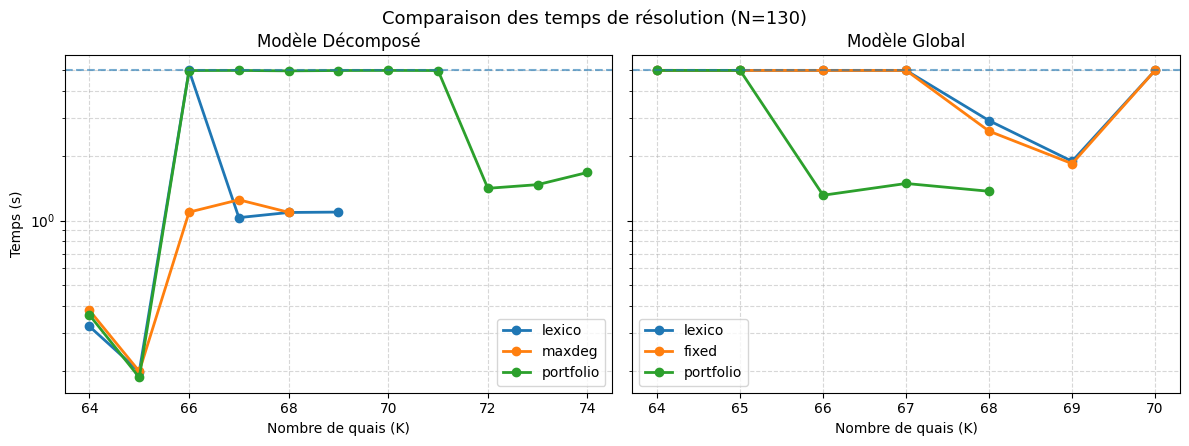

Figure combinée générée : comparison_time.png
✅ Figure déplacée dans /content/Train-Platform-Optimization-CSP/results


In [6]:
from pathlib import Path
import matplotlib.pyplot as plt

def plot_results_notebook(df, n_trains: int, tlimit: float):

    if df.empty:
        print("Aucun résultat.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharey=True)

    # ===================
    # MODELE DECOMPOSE
    # ===================
    df_dec = df[df["model"] == "decomposed"]

    for strat in df_dec["strategy"].unique():
        data = df_dec[df_dec["strategy"] == strat].sort_values("k")
        axes[0].plot(data["k"], data["time"], marker="o", linewidth=2, label=strat)

    axes[0].set_title("Modèle Décomposé")
    axes[0].set_xlabel("Nombre de quais (K)")
    axes[0].set_ylabel("Temps (s)")
    axes[0].set_yscale("log")
    axes[0].axhline(y=tlimit, linestyle="--", alpha=0.6)
    axes[0].grid(True, which="both", linestyle="--", alpha=0.5)
    axes[0].legend()

    # =======================
    # MODELE GLOBAL (droite)
    # =======================
    df_glob = df[df["model"] == "global"]

    for strat in df_glob["strategy"].unique():
        data = df_glob[df_glob["strategy"] == strat].sort_values("k")
        axes[1].plot(data["k"], data["time"], marker="o", linewidth=2, label=strat)

    axes[1].set_title("Modèle Global")
    axes[1].set_xlabel("Nombre de quais (K)")
    axes[1].set_yscale("log")
    axes[1].axhline(y=tlimit, linestyle="--", alpha=0.6)
    axes[1].grid(True, which="both", linestyle="--", alpha=0.5)
    axes[1].legend()

    plt.suptitle(f"Comparaison des temps de résolution (N={n_trains})", fontsize=13)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    plt.savefig("comparison_time.png", dpi=150, bbox_inches="tight")
    plt.show()

    print("Figure combinée générée : comparison_time.png")


# ==========================================================
# Sauvegarde résultats + figure combinée
# ==========================================================

results_dir = Path("results")
results_dir.mkdir(exist_ok=True)

# CSV
csv_path = results_dir / "results.csv"
df.to_csv(csv_path, index=False)
print("✅ CSV :", csv_path)

# Génération figure combinée
plot_results_notebook(df, n_trains=n_trains, tlimit=tlimit)

# Déplacement image dans results/
p = Path("comparison_time.png")
if p.exists():
    p.replace(results_dir / "comparison_time.png")

print("✅ Figure déplacée dans", results_dir.resolve())


## 5) Lecture des résultats

On calcule un indicateur simple :  
**K\*** observé = premier `K` tel que le statut est satisfiable (`OPTIMAL` ou `FEASIBLE`) **avant le timeout**.

On l’affiche par couple *(modèle, stratégie)*.


In [7]:
import pandas as pd

df2 = df.copy()
# Normalise TIMEOUT : OR-Tools renvoie parfois UNKNOWN quand le temps est atteint
df2["status_norm"] = df2["status"].replace({"UNKNOWN": "TIMEOUT"})

def k_star(group: pd.DataFrame):
    ok = group[group["status_norm"].isin(["OPTIMAL", "FEASIBLE"])].sort_values("k")
    return None if ok.empty else int(ok.iloc[0]["k"])

kstars = (
    df2.groupby(["model", "strategy"], as_index=False)
       .apply(lambda g: pd.Series({"K_star": k_star(g)}))
       .reset_index(drop=True)
)

kstars


/tmp/ipython-input-4158349408.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({"K_star": k_star(g)}))


,model,strategy,K_star
0,decomposed,lexico,67
1,decomposed,maxdeg,66
2,decomposed,portfolio,72
3,global,fixed,68
4,global,lexico,68
5,global,portfolio,66


## 7) Conclusion (résumé)

Ce notebook fournit :
- un protocole de benchmark reproductible,
- des sorties directement exploitables dans un rapport (CSV + figures),
- une lecture synthétique via **K\***.

Vous pouvez maintenant :
1. pousser le dossier `results/` sur GitHub,
2. utiliser `results/results.csv` pour analyser et commenter la transition de phase,
3. intégrer `results/decomposed_time.png` et `results/global_time.png` dans Overleaf.
